<a href="https://colab.research.google.com/github/Shritej24c/NLP101/blob/main/HW/HW6/ShritejShrikant_Chavan_HW6c.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup Environment and Install Libraries

In [1]:
 # CHANGE FOLDERS AS PER YOUR SETUP
from pathlib import Path
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount("/content/drive")
    !pip install datasets transformers evaluate wandb accelerate seqeval -U -qq
    base_folder = Path("/content/drive/MyDrive/NLP")
else:
    base_folder = Path("/home/harpreet/Insync/google_drive_shaannoor/data")


from transformers import AutoConfig, AutoModelForTokenClassification, AutoTokenizer, Trainer, TrainingArguments
from transformers import AutoTokenizer, DataCollatorForTokenClassification, pipeline
from datasets import load_dataset, DatasetDict, Dataset, ClassLabel, Sequence
import evaluate


import wandb

import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import torch
import gc

import textwrap



Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 20.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 12.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 55.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 28.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 33.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 71.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

## Specify Model & Data Path

In [2]:
# CHANGE FOLDERS TO WHERE YOU WANT TO SAVE DATA AND MODELS
data_folder = base_folder/'datasets/brown_corpus'
model_folder = base_folder/'models/nlp_spring_2023/ner'
model_folder.mkdir(exist_ok=True)
data_folder.mkdir(exist_ok=True)

## Create Functions

In [3]:
def print_wrap(text, d):
    # If the text is a list, convert it to a string
    if isinstance(text, list):
        # Convert None values to a default string (e.g., "None" or an empty string)
        text = ' '.join(str(item) if item is not None else "None" for item in text)

    # Wrap the text to limit the width to 'd'
    wrapped_text = textwrap.fill(text, width=d)

    # Print the wrapped text
    print(wrapped_text)


### Load and Split Dataset

In [4]:
def split_dataset(data = 'conll2003', train = 5000, val_test = 1000):
    conll_dataset = load_dataset(data)

    train_split_small = conll_dataset['train'].shuffle(seed=42).select(range(train))
    val_split_small = conll_dataset['validation'].shuffle(seed=42).select(range(val_test))
    test_split_small = conll_dataset['test'].shuffle(seed=42).select(range(val_test))

    # combine train, val splits into one dataset
    train_val_subset = DatasetDict({'train': train_split_small, 'val': val_split_small})

    # create test dataset from test split
    test_subset = DatasetDict({'test': test_split_small})

    class_names = conll_dataset['train'].features['ner_tags'].feature.names

    return train_val_subset, test_subset, class_names



###  <font color = 'indianred'> **Create function for Tokenizer**

In [5]:

def align_targets(labels, word_ids):

    aligned_labels = []

    previous_word_id = None

    b2i = {1:2, 3:4, 5:6, 7:8}

    for w in word_ids:

        if w is None:

            label = -100
        elif w != previous_word_id:
            label = labels[w]

        else:
            label = labels[w]

            if label in b2i:
                label = b2i[label]


        aligned_labels.append(label)

        previous_word_id = w

    return aligned_labels



  # CODE HERE




### Function for Tokenization

In [6]:
def get_tokenized_dataset(checkpoint, dataset):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    def tokenize_fn(batch):
        """
        Tokenizes a batch of sequences and aligns the target labels with the tokenized outputs.

        Args:
        - batch (dict): A dictionary containing:
            * 'tokens': A list of lists where each inner list contains tokens of a sequence.
            * 'tags': A list of lists where each inner list contains POS tags corresponding to the 'tokens'.

        Returns:
        - dict: A dictionary containing tokenized inputs and their corresponding aligned labels.
        """

        # Tokenize the 'tokens' from the batch. This returns various fields like 'input_ids', 'attention_mask', etc.
        # 'is_split_into_words=True' indicates the input is already tokenized into words.
        # 'truncation=True' ensures sequences longer than the model's max length are truncated.
        tokenized_inputs = tokenizer(batch['tokens'], truncation=True, is_split_into_words=True)

        # Extract the original labels/tags from the batch.
        labels_batch = batch['ner_tags']

        # This list will store the labels aligned with the tokenized input.
        aligned_labels_batch = []

        # Iterate over each example in the batch.
        for i, labels in enumerate(labels_batch):
            # Obtain the word IDs for the tokenized example. This helps in aligning the original labels with the tokens.
            word_ids = tokenized_inputs.word_ids(i)

            # Align the original labels with the tokenized example and append to the aligned_labels_batch list.
            aligned_labels_batch.append(align_targets(labels, word_ids))

        # The HuggingFace trainer expects the labels for token classification tasks to be under the key 'labels'.
        # Store the aligned labels in the 'labels' key of the tokenized_inputs dictionary.
        tokenized_inputs['labels'] = aligned_labels_batch

        return tokenized_inputs

    tokenized_dataset = dataset.map(tokenize_fn, batched=True)

    tokenized_dataset = tokenized_dataset.remove_columns(['tokens', 'ner_tags', 'pos_tags','chunk_tags', 'id'])

    tokenized_dataset.set_format(type='torch')

    return tokenized_dataset

### Function to initialize model

In [7]:
def initialize_model(checkpoint, class_names):
    config = AutoConfig.from_pretrained(checkpoint)
    id2label = {}
    for id_, label_ in enumerate(class_names):
        id2label[str(id_)] = label_

    label2id = {}
    for id_, label_ in enumerate(class_names):
        label2id[label_] = id_

    config.id2label = id2label
    config.label2id = label2id

    model = AutoModelForTokenClassification.from_pretrained(checkpoint, config=config)

    return model, config

### Function to compute metrics

In [8]:
seqeval_metric = evaluate.load('seqeval')
def compute_metrics(logits_and_labels):
    """
    Compute sequence tagging metrics using the seqeval metric.

    Args:
    - logits_and_labels (tuple): A tuple containing model logits and true labels.

    Returns:
    - dict: A dictionary containing precision, recall, f1-score, and accuracy.
    """

    # Separate logits and labels from the input tuple
    logits, true_labels = logits_and_labels

    # Obtain predicted label indices by selecting the label with the highest logit value for each token
    predicted_indices = np.argmax(logits, axis=-1)  # Shape: (batch_size, sequence_length)

    # Convert label indices to their string representation, ignoring special tokens (label index = -100)
    string_true_labels = [[class_names[label_id] for label_id in sequence if label_id != -100] for sequence in true_labels]

    # Convert predicted indices to their string representation, but only for tokens where the true label isn't -100
    string_predictions = [
        [class_names[pred_id] for pred_id, true_label_id in zip(pred_sequence, true_sequence) if true_label_id != -100]
        for pred_sequence, true_sequence in zip(predicted_indices, true_labels)
    ]

    # Compute the metrics using seqeval
    metrics_results = seqeval_metric.compute(predictions=string_predictions, references=string_true_labels)

    return {
        'precision': metrics_results['overall_precision'],
        'recall': metrics_results['overall_recall'],
        'f1': metrics_results['overall_f1'],
        'accuracy': metrics_results['overall_accuracy']
    }

  # CODE HERE



### Function to set Trainer

In [9]:
def get_trainer(model, training_args, train_dataset, eval_dataset, compute_metrics, tokenizer, data_collator):
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=eval_dataset,
        compute_metrics=compute_metrics,
        tokenizer=tokenizer,
        data_collator= data_collator
    )
    return trainer

### Plot Confusion Matrix

In [10]:
def log_and_plot_confusion_matrix(trainer, tokenized_val_dataset, class_names):
    # Perform prediction using the trainer
    valid_output = trainer.predict(tokenized_val_dataset)

    # Convert the logits (raw prediction scores) from the valid_output object into class predictions.
    # For each input, pick the class with the highest logit as the predicted class.
    # Also, extract the true label IDs from valid_output and store them as an array for further analysis.
    valid_predictions = np.argmax(valid_output.predictions, axis=2)
    valid_labels = np.array(valid_output.label_ids)

    # 2. Filter out any tokens with label -100 (typically used for padding or special tokens)
    mask = valid_labels != -100
    filtered_predictions = valid_predictions[mask]
    filtered_labels = valid_labels[mask]

        # log the Confusion Matrix to Wandb
    wandb.log({
        "conf_mat": wandb.plot.confusion_matrix(
            preds=filtered_predictions,        # Model's predicted class labels.
            y_true=filtered_labels,      # Actual labels from the validation set.
            class_names=class_names   # Custom class names for display in the confusion matrix.
        )
    })

    # Plot the confusion matrix using Matplotlib
    fig, ax = plt.subplots(figsize=(8, 6))
    ConfusionMatrixDisplay.from_predictions(
        y_true=filtered_labels,
        y_pred=filtered_predictions,
        ax=ax,
        normalize="true",
        display_labels=class_names,
        xticks_rotation=90
    )
    plt.show()

In [11]:
def free_memory():
    """
    Attempts to free up memory by deleting variables and running Python's garbage collector.
    """
    gc.collect()
    for device_id in range(torch.cuda.device_count()):
        torch.cuda.set_device(device_id)
        torch.cuda.empty_cache()
    gc.collect()

### Function to tokenize dataset and, train and eval models

In [12]:
def tokenize_train_evaluate_log(training_args, checkpoint, base_folder,
                             class_names, train_val_subset, compute_metrics):
    # 1. Free memory
    free_memory()

    # 2. Setup wandb
    wandb.login()
    %env WANDB_PROJECT = nlp_course_fall_2023-HW6-PartC

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################

    # MAKE SURE THE BASE FOLDER IS SETUP CORRECTLY
    #  YOU CAN CHANGE THIS LINE IF YOU WANT TO SAVE IN A DIFFERENT FOLDER

    model_folder = base_folder / "models" / "nlp_spring_2023/ner"/checkpoint
    model_folder.mkdir(exist_ok=True, parents=True)

    ######################## ALLOWED TO CHANGE THIS BLOCK ################################################


    # 3. Get Tokenized Dataset and Data Collator
    train_val_tokenized_dataset = get_tokenized_dataset(checkpoint, train_val_subset)

    # 4. Initialize Model and Tokenizer
    model, config = initialize_model(checkpoint, class_names)
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)

    # 5. Initialize Trainer
    data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer,
                                                  padding=True,
                                                  label_pad_token_id=-100,
                                                  return_tensors='pt') # CODE HERE

    trainer = get_trainer(model, training_args, train_val_tokenized_dataset['train'],
                          train_val_tokenized_dataset['val'], compute_metrics, tokenizer, data_collator)

    # 6. Train and Evaluate
    trainer.train()
    trainer.evaluate(train_val_tokenized_dataset['val'])

    # 7. Log Metrics and Plot
    log_and_plot_confusion_matrix(trainer, train_val_tokenized_dataset['val'], class_names)

    best_model_checkpoint_step = trainer.state.best_model_checkpoint.split('-')[-1]
    wandb.log({"best_model_checkpoint_step": best_model_checkpoint_step})
    print(f"The best model was saved at step {best_model_checkpoint_step}.")

    wandb.finish()

    return best_model_checkpoint_step

## Experiments

### Experiment 1 - BERT base uncased and Choosing F1 as evaluation metric

In [13]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_spring_2023/ner"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

In [14]:
train_val_subset, test_subset, class_names = split_dataset()



Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]

In [15]:
checkpoint = 'bert-base-uncased' # CODE HERE
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1697: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


<IPython.core.display.Javascript object>

wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-PartC


Map:   0%|          | 0/5000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


wandb: Currently logged in as: shritej24c (redeem_team). Use `wandb login --relogin` to force relogin


You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.239200,0.752138,0.000000,0.000000,0.000000,0.792906
40,0.635900,0.443938,0.534572,0.400780,0.458108,0.874112
60,0.410600,0.309361,0.441014,0.533445,0.482846,0.901426
80,0.293200,0.238168,0.558105,0.637124,0.595003,0.928530
100,0.230900,0.179457,0.678974,0.738016,0.707265,0.948266
120,0.193300,0.152880,0.722711,0.778707,0.749665,0.957213
140,0.197500,0.134805,0.757991,0.832776,0.793625,0.963581
160,0.192800,0.126873,0.767765,0.831104,0.798180,0.964265
180,0.159300,0.111249,0.792463,0.855630,0.822836,0.969212
200,0.139000,0.099706,0.817170,0.859532,0.837816,0.972423


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


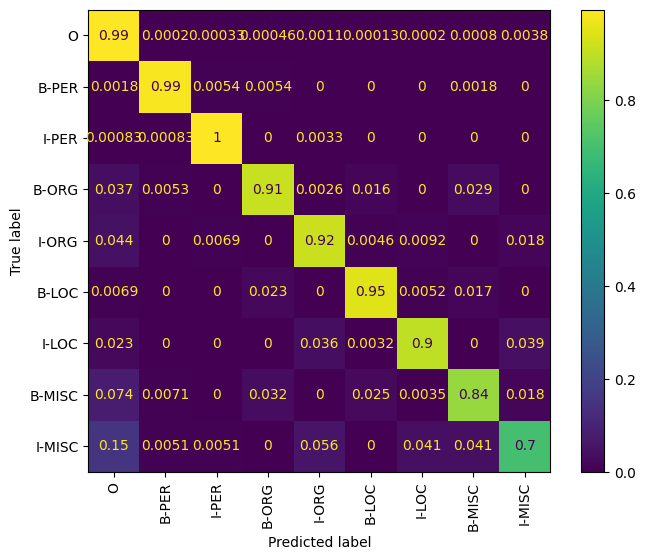

The best model was saved at step 480.


eval/accuracy,▁▄▅▆▇▇▇▇████████████████████████
eval/f1,▁▅▅▆▇▇▇▇▇███████████████████████
eval/loss,█▅▃▃▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▅▅▅▆▇▇▇▇███████████████████████
eval/recall,▁▄▅▆▇▇▇▇████████████████████████
eval/runtime,▁█▅▅▂▂▂▃▂▁▁▁▂▂▃▂▄▂▂▃▄▇▂▃▂▃▂▂▃▃▆▅
eval/samples_per_second,█▁▃▄▇▇▇▆▇███▆▆▅▆▅▇▇▆▄▂▇▆▇▆▇▆▆▆▃▄
eval/steps_per_second,█▁▃▄▇▇▇▆▇███▆▆▅▆▅▇▇▆▄▂▇▆▇▆▇▆▆▆▃▄
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▆▆▆▆▆▇▇▇▇▇▇█████
train/learning_rate,███▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▄▃▃▃▃▂▂▂▂▁▁▁


In [16]:
best_model = tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

In [18]:
from transformers import AutoModelForTokenClassification, AutoTokenizer


test_subset_tokenized = get_tokenized_dataset(checkpoint, test_subset)

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 5. Initialize Trainer
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer,
                                                padding=True,
                                                label_pad_token_id=-100,
                                                return_tensors='pt') # CODE HERE


checkpoint = str(model_folder / "checkpoint-{}".format(best_model))


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)



trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


In [19]:
results


{'eval_loss': 0.11766493320465088,
 'eval_precision': 0.836027713625866,
 'eval_recall': 0.8850855745721271,
 'eval_f1': 0.8598574821852731,
 'eval_accuracy': 0.9703125,
 'eval_runtime': 1.5092,
 'eval_samples_per_second': 662.598,
 'eval_steps_per_second': 41.744}

### Experiment 2 - Changing Subset of the training Data from 5k to 10k and val & test from 1k to 2k & Choosing F1 as evaluation metric

In [20]:
# Define the directory where model checkpoints will be saved
model_folder = base_folder / "models"/"nlp_spring_2023/ner"
# Create the directory if it doesn't exist
model_folder.mkdir(exist_ok=True, parents=True)

# Configure training parameters
training_args = TrainingArguments(
    # Training-specific configurations
    num_train_epochs=2,  # Total number of training epochs
    # Number of samples per training batch for each device
    per_device_train_batch_size=16,
    # Number of samples per evaluation batch for each device
    per_device_eval_batch_size=16,
    weight_decay=0.01,  # Apply L2 regularization to prevent overfitting
    learning_rate=2e-5,  # Step size for the optimizer during training
    optim='adamw_torch',  # Optimizer,

    # Checkpoint saving and model evaluation settings
    output_dir=str(model_folder),  # Directory to save model checkpoints
    evaluation_strategy='steps',  # Evaluate model at specified step intervals
    eval_steps=20,  # Perform evaluation every 10 training steps
    save_strategy="steps",  # Save model checkpoint at specified step intervals
    save_steps=20,  # Save a model checkpoint every 10 training steps
    load_best_model_at_end=True,  # Reload the best model at the end of training
    save_total_limit=2,  # Retain only the best and the most recent model checkpoints
    # Use 'accuracy' as the metric to determine the best model
    metric_for_best_model="f1",
    greater_is_better=True,  # A model is 'better' if its accuracy is higher


    # Experiment logging configurations (commented out in this example)
    logging_strategy='steps',
    logging_steps=20,
    report_to='wandb',  # Log metrics and results to Weights & Biases platform
    run_name= 'ner_exp1',  # Experiment name for Weights & Biases
)

In [21]:
train_val_subset, test_subset, class_names = split_dataset(train = 10000, val_test = 2000)


In [22]:
checkpoint = 'distilbert-base-uncased' # CODE HERE
training_args_dict = training_args.to_dict() # Convert TrainingArguments to dictionary
training_args_dict['run_name'] = f'{checkpoint}' # Update the run_name
new_training_args = TrainingArguments(**training_args_dict)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1697: FutureWarning: `--push_to_hub_token` is deprecated and will be removed in version 5 of 🤗 Transformers. Use `--hub_token` instead.
  warnings.warn(


env: WANDB_PROJECT=nlp_course_fall_2023-HW6-PartC


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Some weights of DistilBertForTokenClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
20,1.334400,0.847490,0.000000,0.000000,0.000000,0.789764
40,0.692400,0.544464,0.051325,0.008422,0.014469,0.814450
60,0.449300,0.385389,0.564370,0.574029,0.569158,0.889686
80,0.296000,0.295977,0.582893,0.629449,0.605277,0.917723
100,0.295500,0.239433,0.592467,0.666667,0.627381,0.932225
120,0.230700,0.203815,0.684960,0.718826,0.701485,0.943037
140,0.241800,0.175436,0.738918,0.778864,0.758365,0.953665
160,0.187900,0.154096,0.767700,0.807118,0.786916,0.958613
180,0.167700,0.149117,0.763289,0.834827,0.797457,0.959895
200,0.171800,0.146521,0.758162,0.820158,0.787942,0.958770


/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


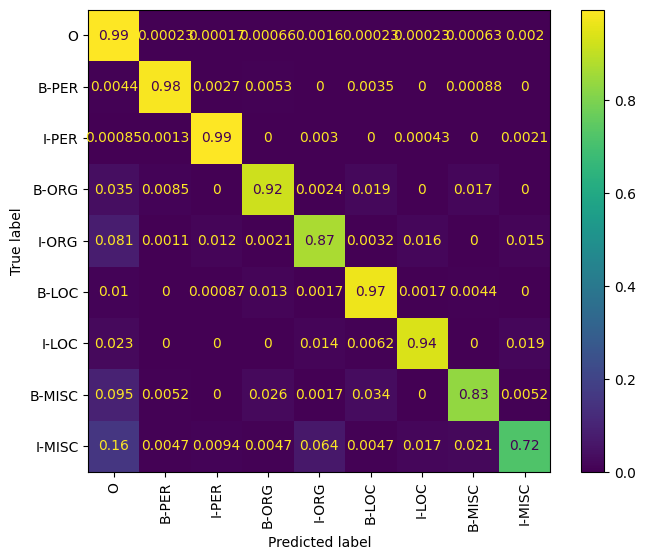

The best model was saved at step 1000.


eval/accuracy,▁▂▆▆▇▇▇██▇██████████████████████████████
eval/f1,▁▁▆▆▇▇▇▇▇▇██████████████████████████████
eval/loss,█▅▃▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
eval/precision,▁▁▆▆▇▇▇▇▇▇▇█████████████████████████████
eval/recall,▁▁▆▆▇▇▇██▇██████████████████████████████
eval/runtime,▂▁▃▆▂▂▂▂▂▁▂▂▃▅▅▂▂▂▁▁▂▅▂▂▄▅█▅▃▆▃▂▅▂▃▁▂▂▂▂
eval/samples_per_second,▆█▅▃▇▇▆▇▇█▇▆▆▄▄▇▇▇██▆▄▇▇▄▃▁▃▆▃▅▇▄▇▆█▇▇▇▇
eval/steps_per_second,▆█▅▃▇▇▆▇▇█▇▆▆▄▄▇▇▇██▆▄▇▇▄▃▁▃▆▃▅▇▄▇▆█▇▇▇▇
train/epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/global_step,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▄▄▄▄▄▄▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇████
train/learning_rate,████▇▇▇▇▇▆▆▆▆▆▆▅▅▅▅▅▄▄▄▄▄▄▃▃▃▃▃▂▂▂▂▂▂▁▁▁


In [23]:
best_model = tokenize_train_evaluate_log(training_args= new_training_args, checkpoint=checkpoint, base_folder=base_folder,
                             class_names=class_names, train_val_subset=train_val_subset,
                             compute_metrics=compute_metrics)

In [24]:
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

# 5. Initialize Trainer
data_collator = DataCollatorForTokenClassification(tokenizer = tokenizer,
                                                padding=True,
                                                label_pad_token_id=-100,
                                                return_tensors='pt') # CODE HERE


checkpoint = str(model_folder / "checkpoint-{}".format(best_model))


tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForTokenClassification.from_pretrained(checkpoint)

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    per_device_eval_batch_size=16,  # adjust based on your GPU memory
    do_train = False,
    do_eval=True,
    report_to=[]  # disable logging
)



trainer = Trainer(
    model=model,
    args=training_args,
    eval_dataset=test_subset_tokenized['test'],  # Make sure this dataset is tokenized!
    tokenizer=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics,
)

results = trainer.evaluate()

results

You're using a DistilBertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


{'eval_loss': 0.10696234554052353,
 'eval_precision': 0.8479154433352907,
 'eval_recall': 0.882640586797066,
 'eval_f1': 0.8649296196466009,
 'eval_accuracy': 0.9718149038461539,
 'eval_runtime': 1.1845,
 'eval_samples_per_second': 844.219,
 'eval_steps_per_second': 53.186}

For NER classification I have tried 2 experiments

1. Using more complex model BERT over DistillBERT and changing the evaluation metric to F1 and got Test F1-score = 0.85986 and Accuracy = 0.9703 over the previous model of DistillBERT F1-score = 0.8319 and Accuracy = 0.9651

2. Here I used the 2x the subset of the data than our previous model and used F-1 evaluation metric and got Evaluation F1-score = 0.86493 and Accuracy = 0.97181 over the previous model of DistillBERT and lesser subset of data with F1-score = 0.8319 and Accuracy = 0.9651


We can conclude that using larger model, proper metric and more data will definitely yeild better results on Test Data set